In [1]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import matplotlib.pyplot as plt
from PIL import Image
import torch.nn as nn
import numpy as np
import os, json
from glob import glob
from tqdm.notebook import tqdm
from joblib import Parallel, delayed

import torch
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn.functional as F

import timm

In [2]:
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    return transf(img).unsqueeze(0)

In [3]:
ckpt_fn = "models/20220703-182810-resnet50-224/last.pth.tar"
im_path = "data/orig_o"
out_path = "o_o"

fl_dict = {}
for idx, fl in enumerate(glob(f"{im_path}/*")):
    bn = os.path.basename(fl)
    fl_dict[bn] = idx
    
images = []
for im_fn in glob(f"{im_path}/**/*.*", recursive=True):
    bn = os.path.basename(im_fn)
    images.append(im_fn)
    
print(len(images))

4577


In [4]:
model = timm.create_model(
        'resnet50',
        num_classes=300,
        in_chans=3,
        pretrained=True,
        checkpoint_path=ckpt_fn)

target_layers = model.layer4

In [ ]:
'''GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad'''

def process(im_fn, fl_dict):
    curr_dir = dir()
    cam_list = [
    ["gradcam", GradCAM(model=model, target_layers=target_layers)],
    ["gradcampp", GradCAMPlusPlus(model=model, target_layers=target_layers)],
    ["xgradcam", XGradCAM(model=model, target_layers=target_layers)],
    ["eigencam", EigenCAM(model=model, target_layers=target_layers)],
    ["fullgrad", FullGrad(model=model, target_layers=target_layers)]]
    
    bn = os.path.basename(im_fn)
    cat = fl_dict[im_fn.split("/")[-2]]
    
    img = Image.open(im_fn)
    img_t = get_input_tensors(img)
    test_img = np.array(img.resize((224, 224)), dtype='float32')
    test_img /= 255

    targets = [ClassifierOutputTarget(cat)]
    
    for cam_str, cam_method in cam_list:
        grayscale_cam = cam_method(input_tensor=img_t, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(test_img, grayscale_cam, use_rgb=True)
        plt.imshow(visualization)
        if not os.path.exists(f"outs/{out_path}/{cam_str}/{bn}"):
            try:

                plt.savefig(f"outs/{out_path}/{cam_str}/{bn}")
            except FileNotFoundError:
                os.makedirs(f"outs/{out_path}/{cam_str}/")
            plt.close()
        
        del grayscale_cam
        
    for name in dir():
        if name not in curr_dir and name != "curr_dir":
            del globals()[name]

Parallel(n_jobs=8)(delayed(process)(im_fn, fl_dict) for im_fn in tqdm(images, total=len(list(images))))

  0%|          | 0/4577 [00:00<?, ?it/s]

KeyboardInterrupt: 

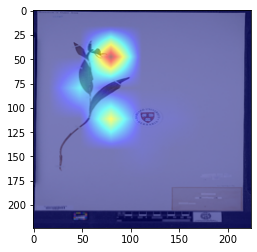

In [5]:
'''GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad'''
for im_fn in tqdm(images, total=len(list(images))):
    curr_dir = dir()
    cam_list = [
    ["gradcam", GradCAM(model=model, target_layers=target_layers)],
    ["gradcampp", GradCAMPlusPlus(model=model, target_layers=target_layers)],
    ["xgradcam", XGradCAM(model=model, target_layers=target_layers)],
    ["eigencam", EigenCAM(model=model, target_layers=target_layers)],
    ["fullgrad", FullGrad(model=model, target_layers=target_layers)]]
    
    bn = os.path.basename(im_fn)
    cat = fl_dict[im_fn.split("/")[-2]]
    
    img = Image.open(im_fn)
    img_t = get_input_tensors(img)
    test_img = np.array(img.resize((224, 224)), dtype='float32')
    test_img /= 255

    targets = [ClassifierOutputTarget(cat)]
    
    for cam_str, cam_method in cam_list:
        grayscale_cam = cam_method(input_tensor=img_t, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(test_img, grayscale_cam, use_rgb=True)
        plt.imshow(visualization)
        if not os.path.exists(f"outs/{out_path}/{cam_str}/{bn}"):
            try:

                plt.savefig(f"outs/{out_path}/{cam_str}/{bn}")
            except FileNotFoundError:
                os.makedirs(f"outs/{out_path}/{cam_str}/")
            plt.close()
        
        del grayscale_cam
        
    for name in dir():
        if name not in curr_dir and name != "curr_dir":
            del globals()[name]

In [6]:
cam_str = "scorecam"
cam_method = ScoreCAM(model=model, target_layers=target_layers)

for im_fn in tqdm(images, total=len(list(images))):
    curr_dir = dir()
    
    bn = os.path.basename(im_fn)
    cat = fl_dict[im_fn.split("/")[-2]]
    
    img = Image.open(im_fn)
    img_t = get_input_tensors(img)
    test_img = np.array(img.resize((224, 224)), dtype='float32')
    test_img /= 255

    targets = [ClassifierOutputTarget(cat)]
    
    grayscale_cam = cam_method(input_tensor=img_t, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(test_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    if not os.path.exists(f"outs/{out_path}/{cam_str}/{bn}"):
        try:

            plt.savefig(f"outs/{out_path}/{cam_str}/{bn}")
        except FileNotFoundError:
            os.makedirs(f"outs/{out_path}/{cam_str}/")
        plt.close()

    del grayscale_cam

    for name in dir():
        if name not in curr_dir and name != "curr_dir":
            del globals()[name]

  0%|          | 0/4577 [00:00<?, ?it/s]


 54%|████████████████████████████████████████▍                                  | 69/128 [02:36<02:13,  2.26s/it]


100%|██████████████████████████████████████████████████████████████████████████| 128/128 [04:49<00:00,  2.26s/it]

  8%|█████▊                                                                     | 10/128 [00:22<04:22,  2.23s/it]


 62%|██████████████████████████████████████████████▉                            | 80/128 [03:04<01:51,  2.32s/it]


100%|██████████████████████████████████████████████████████████████████████████| 128/128 [04:52<00:00,  2.29s/it]

 16%|███████████▉                                                             | 21/128 [00:48<04:09,  2.33s/it]


 72%|████████████████████████████████████████████████████▍                    | 92/128 [03:29<01:20,  2.22s/it]


100%|████████████████████████████████████████████████████████████████████████| 128/128 [04:49<00:00,  2.26s/it]

 26%|███████████████████▌                                                        | 33/128 [01:13<03:30,  2.22s/it]


 80%|███████████████████████████████████████████████████████████▊               | 102/128 [03:58<01:08,  2.64s/it]


100%|███████████████████████████████████████████████████████████████████████████| 128/128 [04:57<00:00,  2.33s/it]

 33%|████████████████████████▉                                                   | 42/128 [01:37<03:18,  2.31s/it]


 87%|█████████████████████████████████████████████████████████████████          | 111/128 [04:15<00:38,  2.25s/it]


100%|███████████████████████████████████████████████████████████████████████████| 128/128 [04:53<00:00,  2.29s/it]

 40%|██████████████████████████████▎                                             | 51/128 [01:53<02:50,  2.21s/it]


 94%|██████████████████████████████████████████████████████████████████████▎    | 120/128 [04:26<00:17,  2.21s/it]


100%|███████████████████████████████████████████████████████████████████████████| 128/128 [04:44<00:00,  2.22s/it]

 47%|███████████████████████████████████▋                                        | 60/128 [02:15<02:34,  2.27s/it]


100%|███████████████████████████████████████████████████████████████████████████| 128/128 [04:51<00:00,  2.27s/it]

  0%|                                                                                     | 0/128 [00:00<?, ?it/s]


 54%|████████████████████████████████████████▉                                   | 69/128 [02:43<02:17,  2.34s/it]


 98%|█████████████████████████████████████████████████████████████████████████▊ | 126/128 [04:59<00:04,  2.38s/it]


KeyboardInterrupt: 

In [7]:
cam_str = "ablationcam"
cam_method = AblationCAM(model=model, target_layers=target_layers)

for im_fn in tqdm(images, total=len(list(images))):
    curr_dir = dir()
    
    bn = os.path.basename(im_fn)
    cat = fl_dict[im_fn.split("/")[-2]]
    
    img = Image.open(im_fn)
    img_t = get_input_tensors(img)
    test_img = np.array(img.resize((224, 224)), dtype='float32')
    test_img /= 255

    targets = [ClassifierOutputTarget(cat)]
    
    grayscale_cam = cam_method(input_tensor=img_t, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(test_img, grayscale_cam, use_rgb=True)
    plt.imshow(visualization)
    if not os.path.exists(f"outs/{out_path}/{cam_str}/{bn}"):
        try:

            plt.savefig(f"outs/{out_path}/{cam_str}/{bn}")
        except FileNotFoundError:
            os.makedirs(f"outs/{out_path}/{cam_str}/")
        plt.close()

    del grayscale_cam

    for name in dir():
        if name not in curr_dir and name != "curr_dir":
            del globals()[name]

  0%|          | 0/4577 [00:00<?, ?it/s]


 44%|█████████████████████████████████▋                                           | 28/64 [01:35<02:02,  3.40s/it]


KeyboardInterrupt: 